In [1]:
import sys
import numpy as np
import time
import ujson as json

%matplotlib inline
import random
import pandas as pd
from matplotlib import pyplot as plt 

import os
os.chdir('/xdisk/msurdeanu/fanluo/hotpotQA/')
from util import get_buckets
import itertools
import re

## HopotQA dataset

### Train Statistics

In [3]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
train_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [4]:
pd.set_option('display.max_colwidth', None)    # display full (non-truncated) column
train_question_df.head(3)

supporting_facts  \
0                                       [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                          [[Oberoi family, 0], [The Oberoi Group, 0]]   
2  [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   

    level  \
0  medium   
1  medium   
2    hard   

                                                                                                                          question  \
0                                                           Which magazine was started first Arthur's Magazine or First for Women?   
1                                                The Oberoi family is part of a hotel company that has a head office in what city?   
2  Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [5]:
train_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   supporting_facts  90447 non-null  object
 1   level             90447 non-null  object
 2   question          90447 non-null  object
 3   context           90447 non-null  object
 4   answer            90447 non-null  object
 5   _id               90447 non-null  object
 6   type              90447 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB


#### level

In [6]:
# Distribution of difficulty levels
grouped = train_question_df.groupby(['level'])
level_counts = grouped.size()  # count of each 
level_counts

level
easy      17972
hard      15661
medium    56814
dtype: int64

#### type

In [7]:
train_question_df.type.describe()

count      90447
unique         2
top       bridge
freq       72991
Name: type, dtype: object

In [8]:
# Distribution of type
grouped = train_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        72991
comparison    17456
dtype: int64

#### context 

In [9]:
train_question_df['context_flattened'] = train_question_df['context'].map(lambda x: list(itertools.chain.from_iterable(itertools.chain(para[1] for para in x))))

In [10]:
train_question_df['context_joint'] = train_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [11]:
import string
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

import re
import string
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(re.escape(w.strip(string.punctuation))), flags=re.IGNORECASE).search
    # strip(string.punctuation) to remove heading and ending punctuations in the answer, otherwise can not found correctly if heading or ending punctuations appears

In [12]:
train_question_df.context_joint  = train_question_df.context_joint.map(normalize_answer)  
# train_question_df.context_joint  = train_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [13]:
train_question_df.head(1)

supporting_facts   level  \
0  [[Arthur's Magazine, 0], [First for Women, 0]]  medium   

                                                                 question  \
0  Which magazine was started first Arthur's Magazine or First for Women?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [14]:
train_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences

count    90447.000000
mean        40.944907
std         11.207428
min          2.000000
25%         34.000000
50%         40.000000
75%         47.000000
max        144.000000
Name: context_flattened, dtype: float64

In [15]:
grouped = train_question_df.groupby(train_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
2       8
3      36
4      51
5      52
6      57
       ..
133     2
134     1
136     4
142     1
144     2
Length: 134, dtype: int64

In [16]:
num_of_context_sentences.max()

3788

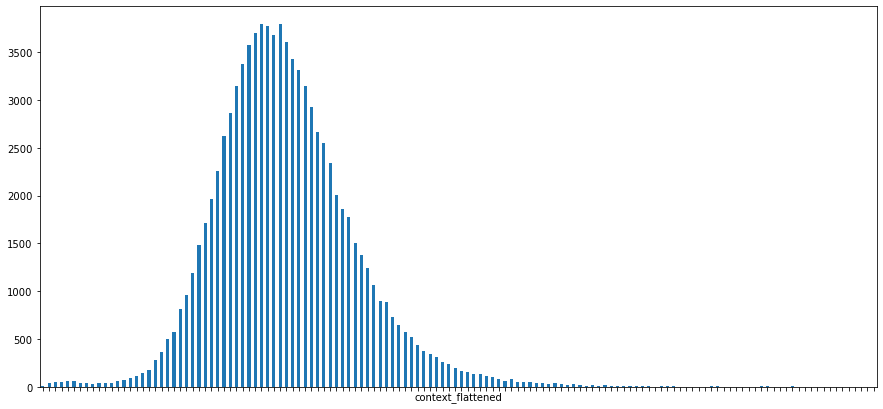

In [17]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [18]:
train_question_df.answer = train_question_df.answer.map(normalize_answer)  # apply normalize_answer(answer)  

In [19]:
train_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    90447.000000
mean         2.144328
std          1.641551
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         76.000000
Name: answer, dtype: float64

In [20]:
grouped = train_question_df.groupby(train_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  
num_of_answer_words

answer
1     32984
2     32024
3     16665
4      4980
5      2003
6       663
7       328
8       159
9       112
10       85
11       70
12       42
13       45
14       42
15       30
16       34
17       23
18       27
19       18
20       17
21       11
22       14
23       12
24       11
25       12
26        5
27        4
28        3
29        3
30        5
31        2
32        3
33        3
34        1
35        2
38        1
40        1
57        1
72        1
76        1
dtype: int64

In [21]:
# number of questions with answer 'yes'
train_question_df.loc[train_question_df['answer'] == 'yes'].shape[0]

2748

In [22]:
# number of comparison questions with answer 'yes'
train_question_df.loc[(train_question_df['answer'] == 'yes') & (train_question_df['type'] == 'comparison')].shape[0]

2748

In [23]:
# number of questions with answer 'no'
train_question_df.loc[train_question_df['answer'] == 'no'].shape[0]

2735

In [24]:
# number of comparison questions with answer 'no'
train_question_df.loc[(train_question_df['answer'] == 'no') & (train_question_df['type'] == 'comparison')].shape[0]

2735

questions with answer yes/no are all comparison questions, and (17456-2735-2748) = 68.6% comparison questions have span answers 

In [25]:
# train_question_df["normalized_answer_in_context"] = train_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [26]:
train_question_df['normalized_answer_in_context'] = train_question_df.apply(lambda row:  findWholeWord(row['answer'])(row['context_joint']) is not None , axis = 1)

In [27]:
train_question_df.normalized_answer_in_context.describe()

count     90447
unique        2
top        True
freq      85441
Name: normalized_answer_in_context, dtype: object

85441 questions' answer in the context, 90447-85441 = 5006 questions' answer are not in the context

In [28]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no')].head(3)

supporting_facts  \
2           [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   
458  [[Be Right There, 0], [Be Right There, 2], [The Warriors Gate, 0], [The Warriors Gate, 1]]   
542                 [[Jeremy Brock, 0], [The Eagle (2011 film), 0], [The Eagle (2011 film), 1]]   

      level  \
2      hard   
458    easy   
542  medium   

                                                                                                                            question  \
2    Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   
458                                                                                                 What genre is The Warriors Gate?   
542                      Jeremy Brock is the writer and director of this 2011 drama that was adapted from him and what other female?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [29]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     5006
unique     227
top        yes
freq      2738
Name: answer, dtype: object

In [30]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no')].answer.describe()

count             264
unique            225
top       south korea
freq                8
Name: answer, dtype: object

In [31]:
train_question_df.iloc[38543].answer

'3oh3'

In [32]:
train_question_df.iloc[38543].context_joint

'regina ilyinichna spektor russian реги́нa ильи́нична спе́ктор born february 18 1980 is russianborn american singersongwriter and pianist she was born in moscow former soviet union now russia and began classical training on piano at age of six when she was nine years old her family emigrated from soviet union to united states where she continued her classical training into her teenage years she began to write original songs shortly thereafter 3oh 3 pronounced three oh three is american electronic music duo from boulder colorado made up of sean foreman and nathaniel motte they are best known for their single dont trust me from their album want which reached number seven on billboard hot 100 their second single remix of starstrukk featuring katy perry from want was top ten hit in united kingdom ireland finland poland and australia they gained further recognition by featuring kesha on song my first kiss which was made lead single from their album streets of gold album later peaked at numb

#### supporting facts

In [33]:
train_question_df['invalid_supporting_facts_ids'] = train_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [34]:
train_question_df['invalid_supporting_facts_ids'].describe()

count     90447
unique        2
top       False
freq      90425
Name: invalid_supporting_facts_ids, dtype: object

22 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [35]:
train_question_df.loc[train_question_df['invalid_supporting_facts_ids']==True]

supporting_facts  \
514                             [[Pro Wrestling Fujiwara Gumi, 0], [Pro Wrestling Fujiwara Gumi, 1], [Minoru Suzuki, 0], [Minoru Suzuki, 1], [Minoru Suzuki, 2]]   
8332                                                                             [[The Lion King, 0], [Jonathan Taylor Thomas, 1], [Jonathan Taylor Thomas, 20]]   
9548                                                                                [[Suite française (Poulenc), 0], [Francis Poulenc, 0], [Francis Poulenc, 3]]   
13415                                                                [[Guillermo del Toro, 1], [Pan's Labyrinth, 0], [Pan's Labyrinth, 1], [Pan's Labyrinth, 2]]   
20594           [[Harry Potter and the Chamber of Secrets (film), 0], [Harry Potter and the Chamber of Secrets (film), 6], [Rupert Grint, 1], [Rupert Grint, 4]]   
22896                                                         [[Division of Adelaide, 1], [Walkerville, South Australia, 0], [Walkerville, South Australia, 52]]   
27436                                                                                                     [[Ron Shelton, 0], [Khady Sylla, 0], [Khady Sylla, 2]]   
37004                                                                       [[Teenage Mutant Ninja Turtles (1990 film), 2], [Robbie Rist, 0], [Robbie Rist, 52]]   
38579                                                              [[Gaz Coombes, 0], [Gaz Coombes, 2], [Harry Styles, 0], [Harry Styles, 3], [Harry Styles, 4]]   
41267                                                                                   [[Samuel P. Cox, 0], [William T. Anderson, 1], [William T. Anderson, 2]]   
45705                                                   [[Elementary School Musical (South Park), 0], [South Park (season 12), 3], [South Park (season 12), 20]]   
49355                                                        [[Altona Christian Community, 0], [Altona Christian Community, 2], [Hutterite, 1], [Hutterite, 40]]   
50651                                                                    [[Plaza Towers Elementary School, 0], [2013 Moore tornado, 0], [2013 Moore tornado, 2]]   
52080                                                           [[Exotic felines as pets, 0], [Exotic felines as pets, 1], [Savannah cat, 0], [Savannah cat, 2]]   
60885  [[George William Featherstonhaugh, 1], [George William Featherstonhaugh, 2], [Albany and Schenectady Railroad, 1], [Albany and Schenectady Railroad, 30]]   
67475                                                                   [[Bentley compounds, 1], [Bentley compounds, 2], [Buprenorphine, 0], [Buprenorphine, 7]]   
77109                                                             [[Jiminy Glick in Lalawood, 0], [Jiminy Glick in Lalawood, 1], [Jan Hooks, 0], [Jan Hooks, 8]]   
85934                                                                                              [[Carlos Davis, 1], [Drop Dead Fred, 0], [Drop Dead Fred, 2]]   
86118                  [[1989 Valvettiturai massacre, 0], [1989 Valvettiturai massacre, 6], [Minister of Defence (India), 0], [Minister of Defence (India), 11]]   
86193                                   [[Rochester College, 0], [Rochester Hills, Michigan, 0], [Rochester Hills, Michigan, 1], [Rochester Hills, Michigan, 2]]   
88641                                               [[Ahtyba Rubin, 0], [Ahtyba Rubin, 2], [Iowa State Cyclones football, 0], [Iowa State Cyclones football, 4]]   
89961                                                                      [[Venus (film), 0], [Jodie Whittaker, 0], [Jodie Whittaker, 2], [Jodie Whittaker, 3]]   

        level  \
514    medium   
8332     easy   
9548   medium   
13415  medium   
20594  medium   
22896  medium   
27436    easy   
37004  medium   
38579    easy   
41267    hard   
45705  medium   
49355  medium   
50651  medium   
52080    hard   
60885    hard   
67475    hard   
77109  medium   
85934  medium   
86118  medium   
86193  medium   
88641    easy 

In [36]:
print(train_question_df.iloc[514].context[7])
len(train_question_df.iloc[514].context[7])

['Minoru Suzuki', ['Minoru Suzuki (鈴木 実 , Suzuki Minoru , ring name: 鈴木 みのる) (born June 17, 1968) is a Japanese professional wrestler and mixed martial artist who is currently working for New Japan Pro Wrestling (NJPW) as a freelancer.', ' He is the current NEVER Openweight Champion in his first reign.']]


2

In [37]:
train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: [normalize_answer(sp_t + ' ' + dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [38]:
train_question_df.head(3)

supporting_facts  \
0                                       [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                          [[Oberoi family, 0], [The Oberoi Group, 0]]   
2  [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   

    level  \
0  medium   
1  medium   
2    hard   

                                                                                                                          question  \
0                                                           Which magazine was started first Arthur's Magazine or First for Women?   
1                                                The Oberoi family is part of a hotel company that has a head office in what city?   
2  Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [39]:
# add a column to count the number of supporting facts
train_question_df['num_of_supporting_facts'] = train_question_df.supporting_fact_text.str.len()

In [40]:
# Distribution of number of supporting facts
train_question_df.num_of_supporting_facts.describe()

count    90447.000000
mean         2.384402
std          0.672601
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: num_of_supporting_facts, dtype: float64

In [41]:
# Distribution of number of supporting facts
grouped = train_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2     63685
3     20019
4      5805
5       722
6       141
7        52
8        17
9         4
11        1
12        1
dtype: int64

In [42]:
# check thoese questions with more than 8 supportiing facts
train_question_df.loc[train_question_df.num_of_supporting_facts > 8]

supporting_facts  \
1722                                                                   [[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Kazuo Ishiguro, 2], [Yukio Mishima, 0], [Yukio Mishima, 1], [Yukio Mishima, 2], [Yukio Mishima, 3], [Yukio Mishima, 4], [Yukio Mishima, 5], [Yukio Mishima, 6], [Yukio Mishima, 7], [Yukio Mishima, 8]]   
2061   [[Margaret MacDonald (visionary), 3], [Margaret MacDonald (visionary), 4], [Margaret MacDonald (visionary), 5], [Margaret MacDonald (visionary), 6], [Margaret MacDonald (visionary), 7], [Margaret MacDonald (visionary), 8], [Margaret MacDonald (visionary), 9], [John Nelson Darby, 0], [John Nelson Darby, 2]]   
11275                                                                                                                                      [[Rowland Brown, 0], [Rowland Brown, 1], [Rowland Brown, 2], [Rowland Brown, 3], [Mike Nichols, 0], [Mike Nichols, 1], [Mike Nichols, 2], [Mike Nichols, 3], [Mike Nichols, 4]]   
55922                                                                      [[Mental Floss, 0], [Mental Floss, 1], [Mental Floss, 2], [Mental Floss, 3], [Mental Floss, 4], [Mental Floss, 5], [Dr. Dobb's Journal, 0], [Dr. Dobb's Journal, 1], [Dr. Dobb's Journal, 2], [Dr. Dobb's Journal, 3], [Dr. Dobb's Journal, 4]]   
61537                                                    [[The Final Solution (novel), 0], [The Final Solution (novel), 1], [The Final Solution (novel), 2], [The Final Solution (novel), 3], [Professor Moriarty, 0], [Professor Moriarty, 1], [Professor Moriarty, 2], [Professor Moriarty, 3], [Professor Moriarty, 4]]   
72623                                         [[Too Weird to Live, Too Rare to Die!, 0], [Too Weird to Live, Too Rare to Die!, 1], [Too Weird to Live, Too Rare to Die!, 2], [Too Weird to Live, Too Rare to Die!, 3], [Dallon Weekes, 0], [Dallon Weekes, 1], [Dallon Weekes, 2], [Dallon Weekes, 3], [Dallon Weekes, 4]]   

        level  \
1722   medium   
2061     hard   
11275  medium   
55922    easy   
61537    hard   
72623    hard   

                                                                                                                                                                                                              question  \
1722                                                                                                                                             Did Kazuo Ishiguro and Yukio Mishima both move from Japan to England?   
2061   Apart from the founder of the Exclusive Brethren, what is the name of the second person who was sent by the Plymouth Brethren to investigate the outbreak of supernatural gifts of the Holy Spirit in Scotland?   
11275                                                                                                                                                       Who won more Grammy Awards, Mike Nichols or Rowland Brown?   
55922                                                                                                                                      Is the Mental Floss paragraph related to the Dr. Dobb's Journal paragraph?    
61537                                                                                               The Final Solution pays homage to a series where Sherlock Holmes calls his later archenemy the "Napoleon" of what?   
72623                                                               What was the name of the drummer on the Panic at The Disco album where the former lead vocalist (among other titles) for the Brobecks played bass?   

                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [43]:
# add a column: whether each supporting fact contains the answer string or not
train_question_df['normalized_answer_in_supporting_fact'] = train_question_df.apply(lambda row: [ findWholeWord(row['answer'])(f) is not None for f in row['supporting_fact_text']], axis = 1)
train_question_df['normalized_answer_in_supporting_fact']

0                       [True, False]
1                       [False, True]
2        [False, False, False, False]
3                [True, False, False]
4                        [True, True]
                     ...             
90442                   [False, True]
90443             [False, True, True]
90444                   [False, True]
90445                    [True, True]
90446             [False, True, True]
Name: normalized_answer_in_supporting_fact, Length: 90447, dtype: object

In [44]:
train_question_df.head(3)

supporting_facts  \
0                                       [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                          [[Oberoi family, 0], [The Oberoi Group, 0]]   
2  [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   

    level  \
0  medium   
1  medium   
2    hard   

                                                                                                                          question  \
0                                                           Which magazine was started first Arthur's Magazine or First for Women?   
1                                                The Oberoi family is part of a hotel company that has a head office in what city?   
2  Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [45]:
# questions that none of its supporting facts contains the answer string
# that is, rows that train_question_df['supporting_fact_contain_answer'] is a list of false
train_question_df[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

supporting_facts  \
2      [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   
27                                                 [[Pavel Urysohn, 0], [Leonid Levin, 0]]   
28                                        [[The New Pornographers, 0], [Kings of Leon, 0]]   
32                                            [[Jane (magazine), 0], [First for Women, 0]]   
49                                            [[Gin and tonic, 0], [Paloma (cocktail), 0]]   
...                                                                                    ...   
90404                                   [[Patrick McCabe (novelist), 0], [John Braine, 0]]   
90407                            [[Capitol Critters, 0], [20th Century Fox Television, 0]]   
90430                                              [[Chris Marker, 0], [Yvonne Rainer, 0]]   
90434                                                        [[Aglaia, 0], [Valeriana, 0]]   
90437                                         [[Fraxinus, 0], [Fraxinus, 2], [Onoclea, 0]]   

        level  \
2        hard   
27     medium   
28       hard   
32     medium   
49     medium   
...       ...   
90404  medium   
90407  medium   
90430  medium   
90434    easy   
90437  medium   

                                                                                                                                       question  \
2               Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   
27                                                                         Were Pavel Urysohn and Leonid Levin known for the same type of work?   
28                                                                        Are both The New Pornographers and Kings of Leon American rock bands?   
32                                                                                         Are Jane and First for Women both women's magazines?   
49                                                                                Are Gin and tonic and Paloma both cocktails based on tequila?   
...                                                                                                                                         ...   
90404                                                                              Were Patrick McCabe and John Braine of the same nationality?   
90407   Capitol Critters is an animated television series produced in association with a television production subsidiary owned by what person?   
90430                                                                                              Are Chris Marker and Yvonne Rainer American?   
90434                                                    Does Aglaia belongs to Mahogany family and Valeriana belongs to Caprifoliaceae family?   
90437                                                                                  Can Fraxinus and Onoclea both be found in North America?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

According to the results, there are 5810 such questions that the answer string is not in any of the supporting facts.

In [46]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') ].shape[0]

367

In [47]:
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') ]

supporting_facts  \
2             [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   
346                                         [[Dischord Records discography, 0], [Ian MacKaye, 1]]   
458    [[Be Right There, 0], [Be Right There, 2], [The Warriors Gate, 0], [The Warriors Gate, 1]]   
542                   [[Jeremy Brock, 0], [The Eagle (2011 film), 0], [The Eagle (2011 film), 1]]   
719                                                          [[Jang Hoon, 0], [A Taxi Driver, 2]]   
...                                                                                           ...   
89455                    [[Park Kwang-hyun, 0], [Park Kwang-hyun, 1], [Welcome to Dongmakgol, 0]]   
89753                                             [[Paul Bernard Vogel, 0], [Solvil et Titus, 0]]   
89895                                [[Gunnar Andersson (footballer), 1], [Jean-Pierre Papin, 0]]   
90151                                            [[Adam Shankman, 2], [Hairspray (2007 film), 0]]   
90407                                   [[Capitol Critters, 0], [20th Century Fox Television, 0]]   

        level  \
2        hard   
346    medium   
458      easy   
542    medium   
719    medium   
...       ...   
89455    easy   
89753  medium   
89895  medium   
90151    hard   
90407  medium   

                                                                                                                                       question  \
2               Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   
346                                           Where is the record company based that was co founded by the frontman of Minor Threat and Fugazi?   
458                                                                                                            What genre is The Warriors Gate?   
542                                 Jeremy Brock is the writer and director of this 2011 drama that was adapted from him and what other female?   
719                                                                                                  Where was the film A Taxi Driver released?   
...                                                                                                                                         ...   
89455                    From which country hails the film director, who co-wrote 'Welcome to Dongmakgol' the 2005 critical and commercial hit?   
89753                                                         Paul Bernard Vogel developed the watch company that is now based in what country?   
89895     The player who was named the European Footballer of the Year in 1991 is widely considered as one of the best strikers of which team ?   
90151                                                              Whose comedy film, that Adam Shankman's 2007 remake is based off of, was it?   
90407   Capitol Critters is an animated television series produced in association with a television production subsidiary owned by what person?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

According to the results, there are only 367 questions that the answer string is not in any of the supporting facts and the answer is neither 'yes' nor 'no'. <br> In some of the case, the answer across several supporting facts.

In [48]:
# how many supporting facts contains the answer string, that is, the count of 'True'
train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    90447.000000
mean         1.280673
std          0.642553
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [49]:
grouped = train_question_df.groupby(train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     5810
1    56738
2    24939
3     2696
4      210
5       40
6        9
7        5
dtype: int64

In [50]:
# check thoese questions with more than 5 supporting facts contain the answer
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) > 5]

supporting_facts  \
1072                                                                          [[Nemesis (rap crew), 0], [Run-DMC, 0], [Run-DMC, 1], [Run-DMC, 2], [Run-DMC, 4], [Run-DMC, 6], [Run-DMC, 9]]   
12504                                               [[Goal! (film series), 0], [Goal! (film series), 1], [Goal! (film series), 2], [Goal! (film), 0], [Goal! (film), 1], [Goal! (film), 2]]   
15171                        [[Karachi Dolphins, 0], [Karachi Dolphins, 1], [Karachi Dolphins, 2], [Karachi Dolphins, 3], [Karachi Dolphins, 4], [Karachi Dolphins, 5], [Mohammad Sami, 0]]   
18114  [[Hot Stuff (Let's Dance), 0], [Hot Stuff (Let's Dance), 1], [Kano (rapper), 0], [Kano (rapper), 1], [Kano (rapper), 2], [Kano (rapper), 3], [Kano (rapper), 4], [Kano (rapper), 5]]   
21368                 [[Steve Smith (US high jumper), 0], [Steve Smith (US high jumper), 1], [Indianapolis, 0], [Indianapolis, 1], [Indianapolis, 2], [Indianapolis, 3], [Indianapolis, 4]]   
21735                  [[If You've Got Trouble, 1], [If You've Got Trouble, 2], [If You've Got Trouble, 4], [Help! (album), 0], [Help! (album), 1], [Help! (album), 3], [Help! (album), 4]]   
25894                                                                               [[Echium, 0], [Ptilotus, 0], [Ptilotus, 1], [Ptilotus, 2], [Ptilotus, 3], [Ptilotus, 7], [Ptilotus, 9]]   
26083                                                                                  [[Manzanita Sol, 1], [Manzanita Sol, 2], [H-E-B, 0], [H-E-B, 3], [H-E-B, 4], [H-E-B, 5], [H-E-B, 6]]   
37074                     [[1936 NFL Championship Game, 0], [1936 NFL Championship Game, 1], [Polo Grounds, 0], [Polo Grounds, 1], [Polo Grounds, 2], [Polo Grounds, 3], [Polo Grounds, 4]]   
42377                                                                                    [[Niki Juusela, 3], [Niki Juusela, 4], [Football, 0], [Football, 1], [Football, 2], [Football, 3]]   
42899  [[Adavi Ramudu (2004 film), 1], [Adavi Ramudu (2004 film), 2], [Adavi Ramudu (2004 film), 4], [Adavi Ramudu (2004 film), 6], [Prabhas, 0], [Prabhas, 1], [Prabhas, 3], [Prabhas, 4]]   
52131                                                                      [[Copag, 0], [Copag, 1], [Copag, 2], [Copag, 3], [Copag, 4], [Copag, 5], [Copag, 6], [World Series of Poker, 0]]   
63304                                                [[Lake Rosseau, 0], [Lake Rosseau, 3], [Lake Rosseau, 5], [Lake Rosseau, 7], [Lake Rosseau, 8], [Lake Rosseau, 10], [Martin Short, 0]]   
87878                                                                  [[Gos Rater Valencià, 1], [Briard, 0], [Briard, 1], [Briard, 2], [Briard, 3], [Briard, 4], [Briard, 5], [Briard, 6]]   

        level  \
1072     easy   
12504    easy   
15171  medium   
18114    easy   
21368  medium   
21735  medium   
25894    hard   
26083  medium   
37074  medium   
42377  medium   
42899  medium   
52131    hard   
63304  medium   
87878  medium   

                                                                                                                                                                                                                                                                            question  \
1072                                                                                             What hip hop group from Hollis, Queens, New York, founded in 1981 by Joseph Simmons, Darryl McDaniels, and Jason Mizell, was brought out by  the first rap crew from Dallas, Texas?   
12504                               What is a 2006 sports drama film directed by Danny Cannon and starring Kuno Becker as Santiago Muñez that is third in a serries, and the second in the series isfootball films directed by Danny Cannon, Jaume Collet-Serra and Andrew Morahan?    
15171                                                                                                                                                                              For what team is the cricket b

### Dev Statistics

In [51]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_dev_distractor_v1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
dev_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [52]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               7405 non-null   object
 1   answer            7405 non-null   object
 2   question          7405 non-null   object
 3   supporting_facts  7405 non-null   object
 4   context           7405 non-null   object
 5   type              7405 non-null   object
 6   level             7405 non-null   object
dtypes: object(7)
memory usage: 405.1+ KB


#### level

In [53]:
# Distribution of difficulty levels
grouped = dev_question_df.groupby(['level'])
level_counts = grouped.size()  # count of each 
level_counts

level
hard    7405
dtype: int64

#### type

In [54]:
dev_question_df.type.describe()

count       7405
unique         2
top       bridge
freq        5918
Name: type, dtype: object

In [55]:
# Distribution of type
grouped = dev_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        5918
comparison    1487
dtype: int64

#### context 

In [56]:
dev_question_df['context_flattened'] = dev_question_df['context'].map(lambda x: list(itertools.chain.from_iterable(itertools.chain(para[1] for para in x))))

In [57]:
dev_question_df['context_joint'] = dev_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [58]:
dev_question_df.context_joint  = dev_question_df.context_joint.map(normalize_answer)  
# dev_question_df.context_joint  = dev_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [59]:
dev_question_df.head(1)

_id answer  \
0  5a8b57f25542995d1e6f1371    yes   

                                                     question  \
0  Were Scott Derrickson and Ed Wood of the same nationality?   

                        supporting_facts  \
0  [[Scott Derrickson, 0], [Ed Wood, 0]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [60]:
dev_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences

count    7405.000000
mean       41.389196
std        11.292848
min         2.000000
25%        34.000000
50%        40.000000
75%        47.000000
max       147.000000
Name: context_flattened, dtype: float64

In [61]:
grouped = dev_question_df.groupby(dev_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
2      1
3      1
4      4
5      3
6      7
      ..
123    1
126    1
127    1
134    1
147    1
Length: 99, dtype: int64

In [62]:
num_of_context_sentences.max()

328

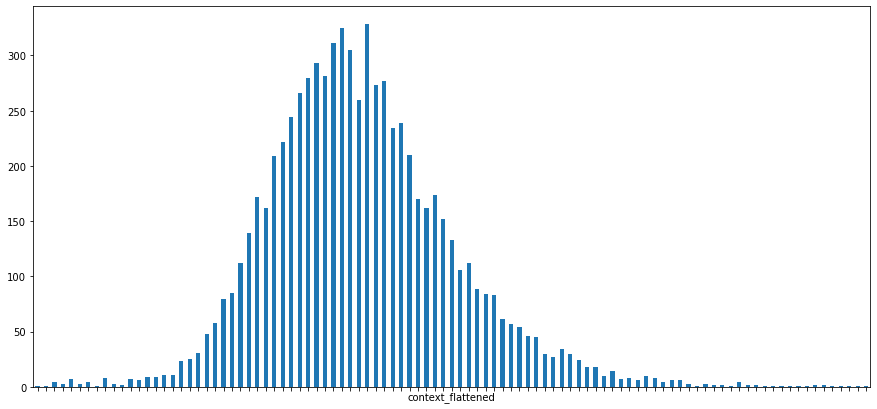

In [63]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [64]:
dev_question_df.answer = dev_question_df.answer.map(normalize_answer)  # apply normalize_answer(answer)  

In [65]:
dev_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    7405.000000
mean        2.360837
std         1.659080
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: answer, dtype: float64

In [66]:
grouped = dev_question_df.groupby(dev_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  # count of each 
num_of_answer_words

answer
1     2441
2     2403
3     1442
4      577
5      247
6      103
7       71
8       44
9       20
10      12
11      11
12      13
13       6
14       5
15       5
16       2
17       1
22       1
28       1
dtype: int64

In [67]:
# number of questions with answer 'yes'
dev_question_df.loc[dev_question_df['answer'] == 'yes'].shape[0]

225

In [68]:
# number of comparison questions with answer 'yes'
dev_question_df.loc[(dev_question_df['answer'] == 'yes') & (dev_question_df['type'] == 'comparison')].shape[0]

225

In [69]:
# number of questions with answer 'no'
dev_question_df.loc[dev_question_df['answer'] == 'no'].shape[0]

233

In [70]:
# number of comparison questions with answer 'no'
dev_question_df.loc[(dev_question_df['answer'] == 'no') & (dev_question_df['type'] == 'comparison')].shape[0]

233

questions with answer yes/no are all comparison questions, and (1487-225-233) = 69.2% comparison questions have span answers 

In [71]:
# dev_question_df["normalized_answer_in_context"] = dev_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [72]:
dev_question_df['normalized_answer_in_context'] = dev_question_df.apply(lambda row:  findWholeWord(row['answer'])(row['context_joint']) is not None , axis = 1)

In [73]:
dev_question_df.normalized_answer_in_context.describe()

count     7405
unique       2
top       True
freq      6993
Name: normalized_answer_in_context, dtype: object

6993 questions' answer in the context, 7405-6993 = 412 questions' answer are not in the context

In [74]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no')].head(3)

_id              answer  \
44   5a760ab65542994ccc918697  nelson rockefeller   
450  5a7252db5542990c210a4104     donald trump jr   
758  5a7f392b55429934daa2fd26            tel aviv   

                                                                                                                                                  question  \
44   Alfred Balk served as the secretary of the Committee on the Employment of Minority Groups in the News Media under which United States Vice President?   
450                                                                 What is the name of the oldest child that attended the Trump campaign-Russian meeting?   
758                                             Wim Jonk manages Cruyff Football together with the footballer who is also currently manager of which team?   

                                                  supporting_facts  \
44   [[Alfred Balk, 0], [Alfred Balk, 2], [Nelson Rockefeller, 0]]   
450   [[Trump campaign–Russian meeting, 0], [Donald Trump Jr., 1]]   
758          [[Wim Jonk, 1], [Jordi Cruyff, 0], [Jordi Cruyff, 1]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [75]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     412
unique     25
top       yes
freq      224
Name: answer, dtype: object

In [100]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no')].answer.describe()

count                24
unique               23
top       j r r tolkien
freq                  2
Name: answer, dtype: object

#### supporting facts

In [77]:
dev_question_df['invalid_supporting_facts_ids'] = dev_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [78]:
dev_question_df['invalid_supporting_facts_ids'].describe()

count      7405
unique        2
top       False
freq       7404
Name: invalid_supporting_facts_ids, dtype: object

1 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [79]:
dev_question_df.loc[dev_question_df['invalid_supporting_facts_ids']==True]

_id    answer  \
5059  5ae61bfd5542992663a4f261  swingman   

                                                                         question  \
5059  Which teams did Jimmy Butler play and what role did he play on these teams?   

                                                                                                  supporting_facts  \
5059  [[Shooting guard, 4], [Shooting guard, 5], [Jimmy Butler (basketball), 0], [Jimmy Butler (basketball), 902]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [80]:
# print(dev_question_df.iloc[514].context[7])
# len(dev_question_df.iloc[514].context[7])

In [81]:
dev_question_df['supporting_fact_text'] = dev_question_df.apply(lambda row: [normalize_answer(sp_t + ' ' + dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [82]:
dev_question_df.head(3)

_id             answer  \
0  5a8b57f25542995d1e6f1371                yes   
1  5a8c7595554299585d9e36b6  chief of protocol   
2  5a85ea095542994775f606a8          animorphs   

                                                                                                                                                  question  \
0                                                                                               Were Scott Derrickson and Ed Wood of the same nationality?   
1                                                   What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?   
2  What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?   

                                                                                                                   supporting_facts  \
0                                                                                             [[Scott Derrickson, 0], [Ed Wood, 0]]   
1                                                        [[Kiss and Tell (1945 film), 0], [Shirley Temple, 0], [Shirley Temple, 1]]   
2  [[The Hork-Bajir Chronicles, 0], [The Hork-Bajir Chronicles, 1], [The Hork-Bajir Chronicles, 2], [Animorphs, 0], [Animorphs, 1]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [83]:
# add a column to count the number of supporting facts
dev_question_df['num_of_supporting_facts'] = dev_question_df.supporting_fact_text.str.len()

In [84]:
# Distribution of number of supporting facts
dev_question_df.num_of_supporting_facts.describe()

count    7405.000000
mean        2.431330
std         0.711328
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: num_of_supporting_facts, dtype: float64

In [85]:
# Distribution of number of supporting facts
grouped = dev_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2    4990
3    1775
4     536
5      80
6      14
7       9
8       1
dtype: int64

In [86]:
# check thoese questions with more than 8 supportiing facts
dev_question_df.loc[dev_question_df.num_of_supporting_facts > 8]

Empty DataFrame
Columns: [_id, answer, question, supporting_facts, context, type, level, context_flattened, context_joint, normalized_answer_in_context, invalid_supporting_facts_ids, supporting_fact_text, num_of_supporting_facts]
Index: []

In [87]:
# add a column: whether each supporting fact contains the answer string or not
dev_question_df['normalized_answer_in_supporting_fact'] = dev_question_df.apply(lambda row: [ findWholeWord(row['answer'])(f) is not None for f in row['supporting_fact_text']], axis = 1)
dev_question_df['normalized_answer_in_supporting_fact']

0                         [False, False]
1                   [False, False, True]
2       [True, False, False, True, True]
3                         [False, False]
4                          [False, True]
                      ...               
7400                 [False, True, True]
7401                      [False, False]
7402                      [False, False]
7403                      [False, False]
7404                       [False, True]
Name: normalized_answer_in_supporting_fact, Length: 7405, dtype: object

In [88]:
dev_question_df.head(3)

_id             answer  \
0  5a8b57f25542995d1e6f1371                yes   
1  5a8c7595554299585d9e36b6  chief of protocol   
2  5a85ea095542994775f606a8          animorphs   

                                                                                                                                                  question  \
0                                                                                               Were Scott Derrickson and Ed Wood of the same nationality?   
1                                                   What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?   
2  What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?   

                                                                                                                   supporting_facts  \
0                                                                                             [[Scott Derrickson, 0], [Ed Wood, 0]]   
1                                                        [[Kiss and Tell (1945 film), 0], [Shirley Temple, 0], [Shirley Temple, 1]]   
2  [[The Hork-Bajir Chronicles, 0], [The Hork-Bajir Chronicles, 1], [The Hork-Bajir Chronicles, 2], [Animorphs, 0], [Animorphs, 1]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [89]:
# questions that none of its supporting facts contains the answer string
# that is, rows that dev_question_df['supporting_fact_contain_answer'] is a list of false
dev_question_df[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

_id answer  \
0     5a8b57f25542995d1e6f1371    yes   
3     5adbf0a255429947ff17385a     no   
9     5a8db19d5542994ba4e3dd00    yes   
13    5ab56e32554299637185c594     no   
17    5ab29c24554299449642c932    yes   
...                        ...    ...   
7349  5a7fe0b55542994857a76818     no   
7373  5ab8736455429916710eb058    yes   
7401  5abba3b1554299642a094aed     no   
7402  5a8173fa554299260e20a28e    yes   
7403  5a8caf1d554299585d9e3720    yes   

                                                                                                    question  \
0                                                 Were Scott Derrickson and Ed Wood of the same nationality?   
3                            Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?   
9                                                   Are Local H and For Against both from the United States?   
13                                      Are Random House Tower and 888 7th Avenue both used for real estate?   
17                                             Are Giuseppe Verdi and Ambroise Thomas both Opera composers ?   
...                                                                                                      ...   
7349                                                       Are The Maine and Black both from Tempe, Arizona?   
7373                                                                     Are Yut and Tsuro both board games?   
7401                             Are both Volvic and Canfield's Diet Chocolate Fudge natural spring waters ?   
7402   Are Billy and Barak both breeds of scenthound? (Barak is also known as a Bosnian Coarse-haired Hound)   
7403  Were both of the following rock groups formed in California: Dig and Thinking Fellers Union Local 282?   

                                                         supporting_facts  \
0                                   [[Scott Derrickson, 0], [Ed Wood, 0]]   
3                          [[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]   
9                                        [[Local H, 0], [For Against, 0]]   
13                         [[Random House Tower, 0], [888 7th Avenue, 2]]   
17                            [[Giuseppe Verdi, 0], [Ambroise Thomas, 0]]   
...                                                                   ...   
7349               [[The Maine (band), 0], [Black (Bangladeshi band), 0]]   
7373                                               [[Yut, 0], [Tsuro, 0]]   
7401  [[Volvic (mineral water), 1], [Canfield's Diet Chocolate Fudge, 0]]   
7402                 [[Bosnian Coarse-haired Hound, 0], [Billy (dog), 0]]   
7403             [[Dig (band), 0], [Thinking Fellers Union Local 282, 0]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

According to the results, there are 489 such questions that the answer string is not in any of the supporting facts.

In [90]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') ].shape[0]

36

In [91]:
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') ]

_id  \
249   5a864ff7554299211dda2af2   
758   5a7f392b55429934daa2fd26   
995   5a81dacc55429926c1cdada0   
1813  5ab3f6935542992339550019   
2211  5ab4b9f75542990594ba9ca4   
2519  5ae7f56e5542993210983fd1   
2522  5adfb78f5542995ec70e9081   
2770  5a7a60f15542990783324f35   
2861  5a86f2fb554299211dda2b64   
3200  5ab2b95c5542991669774072   
3321  5a8463945542992ef85e23d9   
3417  5adddf5d5542997dc7907078   
3554  5a7b4d765542995eb53be8fe   
3700  5a80db5055429938b6142218   
3802  5ab9180b5542991b5579f0f3   
3846  5a80f499554299260e20a1d9   
4012  5a8af0a355429950cd6afc1c   
4099  5a87b2fc5542996e4f3088d0   
4246  5ab1c2bf5542997061209558   
4391  5a84b9c95542997b5ce3ff35   
4395  5adf51595542993344016c52   
4512  5a78bd515542990784727749   
4635  5a8a07725542992d82986e5b   
4758  5ab6644655429954757d327d   
4993  5ae47dd95542995ad6573d57   
5089  5a8bbb8c5542995d1e6f142e   
5628  5a8a5bd355429970aeb702b9   
5706  5ae5d82f554299546bf82f9a   
5750  5ab3d5f355429969a97a81c5   
5855  5adcc5715542990d50227d0a   
6573  5a843cf35542996488c2e51b   
6596  5a7f354b5542992e7d278c8c   
6624  5ac3d1d9554299204fd21e8a   
6788  5ac275e755429921a00aaf81   
6919  5ae7fd085542993210984007   
7294  5a7a73e45542996c55b2ddb6   

                                                                                answer  \
249                                                                       taylor swift   
758                                                                           tel aviv   
995                                                                william shakespeare   
1813                                                                  roleplaying game   
2211                                                             people and carnabeats   
2519                                                                       j k rowling   
2522                                                                      stephen king   
2770                                                            let me make you martyr   
2861                                                                       ian fleming   
3200                                                                         australia   
3321                                                                camille saintsaëns   
3417                                                                              espn   
3554                                                                                12   
3700                                                                       zack snyder   
3802                                                                       south korea   
3846                                                                             dubai   
4012                                                               william shakespeare   
4099                                                                     j r r tolkien   
4246                                                            university of missouri   
4391                                                                  r grandfather hr   
4395                                                                     richard nixon   
4512                                                                   cartoon network   
4635                                                                      steve martin   
4758                                                           football club barcelona   
4993                                                                       barney fife   
5089                                                                          pakistan   
5628                                                                         lithuania   
5706                                                                                 3   
5750                                                                        wes craven   
5855  ÷ pronounced divide is third studio album by english singerson

According to the results, there are only 36 questions that the answer string is not in any of the supporting facts and the answer is neither 'yes' nor 'no'. <br> In some of the case, the answer across several supporting facts.

In [92]:
# how many supporting facts contains the answer string, that is, the count of 'True'
dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    7405.000000
mean        1.203241
std         0.608902
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [93]:
grouped = dev_question_df.groupby(dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     489
1    5171
2    1524
3     199
4      17
5       4
6       1
dtype: int64

In [94]:
# check thoese questions with more than 5 supporting facts contain the answer
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) > 5]

_id answer  \
5470  5a8b3d795542997f31a41cc1          

                                                                                          question  \
5470  Which band included more previously-known figures when it was formed, !!! or Puddle of Mudd?   

                                                                                                        supporting_facts  \
5470  [[!!!, 0], [!!!, 2], [!!!, 3], [Puddle of Mudd, 0], [Puddle of Mudd, 1], [Puddle of Mudd, 2], [Puddle of Mudd, 3]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [95]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   _id                                   7405 non-null   object
 1   answer                                7405 non-null   object
 2   question                              7405 non-null   object
 3   supporting_facts                      7405 non-null   object
 4   context                               7405 non-null   object
 5   type                                  7405 non-null   object
 6   level                                 7405 non-null   object
 7   context_flattened                     7405 non-null   object
 8   context_joint                         7405 non-null   object
 9   normalized_answer_in_context          7405 non-null   bool  
 10  invalid_supporting_facts_ids          7405 non-null   bool  
 11  supporting_fact_text          

## Reduced context with phrase Graph

### Train_reduced_context 

In [40]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))[0]["data"]   
train_reduced_context_df = pd.json_normalize(data, "paragraphs")
 
del data
import gc
gc.collect()

In [41]:
train_reduced_context_df.head(3)

context  \
0  <t> radio city indian radio station </t> it pl...   
1  <t> ritzcarlton jakarta </t>  [/sent] <t> ober...   
2  <t> lisa simpson </t> groening had been invite...   

                                                 qas  
0  [{'answer': 'arthurs magazine', 'id': '5a7a069...  
1  [{'answer': 'delhi', 'id': '5a879ab05542996e4f...  
2  [{'answer': 'president richard nixon', 'id': '...

In [63]:
qas_df = pd.json_normalize(train_reduced_context_df.qas.map(lambda x: x[0])) 
qas_df

answer                        id  \
0                arthurs magazine  5a7a06935542990198eaf050   
1                           delhi  5a879ab05542996e4f30887e   
2         president richard nixon  5a8d7341554299441c6b9fe5   
3                        american  5a82171f5542990a1d231f4a   
4                         alcohol  5a84dd955542997b5ce3ff79   
...                           ...                       ...   
90442                    american  5a8f8db25542997ba9cb32b9   
90443        simon property group  5ae4f3615542993aec5ec0fd   
90444             amblin partners  5a903fc95542990a984935bd   
90445         mv wilhelm gustloff  5ab56e71554299494045efc8   
90446  2017 southeast asian games  5ac28e915542996366519a0a   

                                                question  \
0      Which magazine was started first Arthur's Maga...   
1      The Oberoi family is part of a hotel company t...   
2      Musician and satirist Allie Goertz wrote a son...   
3        What nationality was James Henry Miller's wife?   
4      Cadmium Chloride is slightly soluble in this c...   
...                                                  ...   
90442  Kerry Remsen is the daughter of an actor with ...   
90443  Who manages both Northshore Mall in Peabody, M...   
90444  Charlee Johnson was part of a band that signed...   
90445  What is the ship that sank in the Baltic sea a...   
90446  Vietnam national cricket team will debut at wh...   

                                             is_sup_fact  \
0      [False, False, False, False, False, False, Fal...   
1      [False, False, False, False, False, True, Fals...   
2      [False, False, False, False, False, False, Fal...   
3      [False, False, False, False, False, False, Fal...   
4      [False, True, False, False, False, False, Fals...   
...                                                  ...   
90442  [False, True, False, False, False, False, Fals...   
90443  [False, False, False, False, False, False, Tru...   
90444  [False, False, False, False, False, False, Fal...   
90445  [False, False, False, False, False, False, Fal...   
90446  [True, True, False, False, False, False, False...   

                                      is_supporting_para  
0      [False, False, False, False, False, True, Fals...  
1      [False, True, False, False, False, False, True...  
2      [False, False, False, True, True, False, False...  
3      [False, False, False, False, True, True, False...  
4      [True, False, False, False, False, True, False...  
...                                                  ...  
90442  [True, False, False, False, False, False, Fals...  
90443  [False, True, True, False, False, False, False...  
90444  [False, False, True, False, False, False, Fals...  
90445  [False, False, True, False, True, False, False...  
90446  [True, False, False, False, False, False, Fals...  

[90447 rows x 5 columns]

In [64]:
train_reduced_context_df = pd.concat([train_reduced_context_df.context, qas_df], axis=1)
train_reduced_context_df.head(3)

context                   answer  \
0  <t> radio city indian radio station </t> it pl...         arthurs magazine   
1  <t> ritzcarlton jakarta </t>  [/sent] <t> ober...                    delhi   
2  <t> lisa simpson </t> groening had been invite...  president richard nixon   

                         id  \
0  5a7a06935542990198eaf050   
1  5a879ab05542996e4f30887e   
2  5a8d7341554299441c6b9fe5   

                                            question  \
0  Which magazine was started first Arthur's Maga...   
1  The Oberoi family is part of a hotel company t...   
2  Musician and satirist Allie Goertz wrote a son...   

                                         is_sup_fact  \
0  [False, False, False, False, False, False, Fal...   
1  [False, False, False, False, False, True, Fals...   
2  [False, False, False, False, False, False, Fal...   

                                  is_supporting_para  
0  [False, False, False, False, False, True, Fals...  
1  [False, True, False, False, False, False, True...  
2  [False, False, False, True, True, False, False...

In [65]:
train_reduced_context_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   context             90447 non-null  object
 1   answer              90447 non-null  object
 2   id                  90447 non-null  object
 3   question            90447 non-null  object
 4   is_sup_fact         90447 non-null  object
 5   is_supporting_para  90447 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


In [66]:
train_reduced_context_df.context[0]

'<t> radio city indian radio station </t> it plays hindi english and regional songs [/sent] <t> history of albanian football </t> albanian national team was founded on june 6 1930 but albania had to wait 16 years to play its first international match and then defeated yugoslavia in 1946 [/sent] in 1932 albania joined fifa during 12–16 june convention and in 1954 she was one of founding members of uefa [/sent] <t> echosmith </t> until they signed to warner bros [/sent] <t> womens colleges in southern united states </t> many started first as girls seminaries or academies [/sent] salem college is oldest female educational institution in south and wesleyan college is first that was established specifically as college for women [/sent] some schools such as mary baldwin university and salem college offer coeducational courses at graduate level [/sent] <t> first arthur county courthouse and jail </t>  [/sent] <t> arthurs magazine </t>  [/sent] <t> 2014–15 ukrainian hockey championship </t>  [

number of questions with answer in context:  84933  <br>
number of questions with common_phrases_num_le2:  85192<br>
number of questions with extended phrases:  58402<br>
number of questions with answer in reduced_context:  64245<br>
Time: 22:22:18<br>

In [ ]:
same analyssis on dev
train longformer on context vs reduced_context, run time and performance for traning/dev
 - just over the 64245 questions has answer in the reduced_context

In [ ]:
plan:
    - submit to acl Feb 1rd  
        - longformer results
        - debug and fix
        - error analysis 
        - rest questions not in 64245 ()
        - writing paper (2 weeks)
- send to Mihai
- send to comittee

In [ ]:
proposal: (10~12 pages)
    - intro and motivation
       - reasoning system without logic, approx instead, roubst with graph-based method
    - related works 
        -  qa 
        - KG based
        - multi-hop reasoning   
        - graph-based
        
    - pre results (analysis)
    - plan for the dissertation
       - refer to mithun's proposal under github's paper
        - 3 works
        

In [ ]:
from numpy import loadtxt
reduced_context_ratios = loadtxt("graph_reduced_context_ratios.txt", delimiter=",")
reduced_context_ratios_df = pd.DataFrame(reduced_context_ratios)

In [ ]:
reduced_context_ratios_df.head(3)

In [ ]:
reduced_context_ratios_df.describe()

In [ ]:
non_zero_df = reduced_context_ratios_df[0] ! = 0

### Ranking

#### Sentences Similarity

##### sklearn

###### TF-IDF 

##### glove embedding

##### flair embedding

##### transformer embedding

#### Longformer

In [ ]:
>>> from transformers import LongformerTokenizer, LongformerForQuestionAnswering
>>> import torch

>>> tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")
>>> model = LongformerForQuestionAnswering.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")

In [ ]:
#!python -m pip install flair
from typing import List
from torch.utils.data import Dataset
import torch
from flair.data import Sentence, Corpus
from flair.embeddings import DocumentRNNEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
